# Project Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
import tensorflow as tf
import gzip

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/yann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yann/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data exploration

### Cleaning data algorithm

In [2]:
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re, string

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def clean_single(tweet, stop_words = stopwords.words('english'), numbers=True):

    cleaned_tokens = []
    # Removing links
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', tweet)
    # Removing @
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
        
    # Removing currencies
    tweet = re.sub(r'\$\w*', '', tweet)
    
    tokens = word_tokenize(tweet)
    
    for token, tag in pos_tag(tokens):
                
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
            
            # remove tokens containing numbers
    if numbers:
        numbers = [str(i) for i in range(10)]
        kill_list = []
        for number in numbers:
            kill_list = kill_list + [w for w in cleaned_tokens if number in w]
        # removing selected tokens
        cleaned_tokens = [w for w in cleaned_tokens if not w in kill_list]
        
        # merge tokens
        merged = ' '
        merged = merged.join(cleaned_tokens)
        
    return merged

def clean(array):
    for i, phrase in enumerate(array):
        array[i] = clean_single(phrase)
    return array

### Opening dataset files, cleaning and saving

In [3]:
# df_raw_sentiment = pd.read_csv('data/training.1600000.processed.noemoticon.csv', 
#                           engine='python', 
#                           header=None, 
#                           names=['score', 'tweet_id', 'date', '?', 'account', 'text'])
# df_sentiment = df_raw_sentiment[['score', 'text']]


# classification = np.ones(len(df_sentiment), dtype=np.int)
# classification[df_sentiment['score']==0] = -1

# df_sentiment.insert(loc=2, column='classification', value=classification)
# df_sentiment = df_sentiment[['classification', 'text']]

# sentiment_classification = df_sentiment.classification.values
# sentiment_text = clean(df_sentiment.text.values)

# print(sentiment_classification.shape, sentiment_text.shape)

# temp = pd.DataFrame({'text':sentiment_text,'classification':sentiment_classification})
# temp.to_csv('data/sentiment_cleaned.csv', index=False)

# df_raw_airlines = pd.read_csv('data/Tweets.csv', engine='python')
# df_airlines = df_raw_airlines[['airline_sentiment', 'text']]

# classification = np.zeros(len(df_airlines), dtype=np.int)
# classification[df_airlines['airline_sentiment']=='negative'] = -1
# classification[df_airlines['airline_sentiment']=='neutral'] = 0
# classification[df_airlines['airline_sentiment']=='positive'] = 1

# df_airlines.insert(loc=2, column='classification', value=classification)
# df_airlines = df_airlines[['classification', 'text']]

# airlines_classification = df_airlines.classification.values
# airlines_text = clean(df_airlines.text.values)

# print(airlines_classification.shape, airlines_text.shape)

# temp = pd.DataFrame({'text':airlines_text,'classification':airlines_classification})
# temp.to_csv('data/airlines_cleaned.csv', index=False)

# temp = pd.read_json(r'data/Movies_and_TV_5.json', lines=True)
# temp.head()

In [4]:
# def parse(path):
#     g = gzip.open(path, 'r')
#     for l in g:
#         yield eval(l)

# reviews = []
# scores = []
# for review in parse('data/reviews_Movies_and_TV_5.json.gz'):
#     reviews.append(clean_single(review['reviewText']))
#     scores.append(review['overall'])

# print(len(scores))

#### Opening cleaned data

In [5]:
df_airlines = pd.read_csv('data/airlines_cleaned.csv').dropna()
df_airlines.head()

,text,classification
0,say,0
1,plus 've add commercial experience ... tacky,1
2,n't today ... must mean need take another trip,0
3,'s really aggressive blast obnoxious `` entert...,-1
4,'s really big bad thing,-1


In [6]:
df_sentiment = pd.read_csv('data/sentiment_cleaned.csv').dropna()
df_sentiment.head()

,text,classification
0,awww 's bummer shoulda get david carr third day,-1
1,upset ca n't update facebook texting ... might...,-1
2,dive many time ball managed save rest go bound,-1
3,whole body feel itchy like fire,-1
4,'s behave 'm mad ca n't see,-1


### Visualisation

#### Sentiment repartition over the datasets

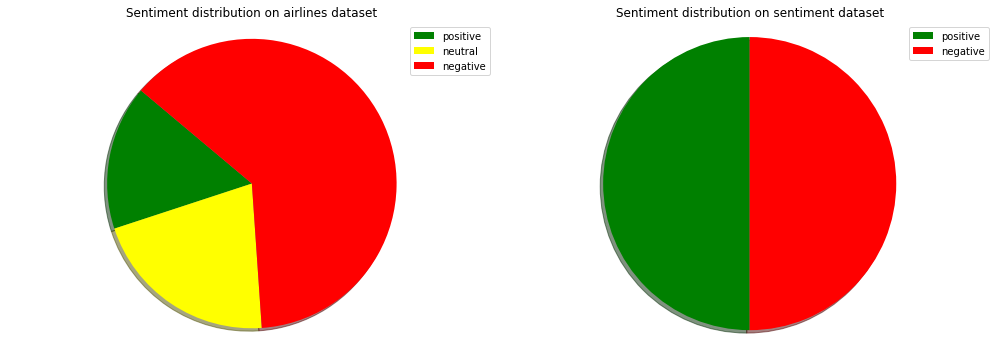

In [7]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
labels = ['positive', 'neutral', 'negative']
sizes = [np.sum(df_airlines.classification==1), np.sum(df_airlines.classification==0), np.sum(df_airlines.classification==-1)]
colors = ['green', 'yellow', 'red']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=140)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.title('Sentiment distribution on airlines dataset')

plt.subplot(1,2,2)
labels = ['positive', 'negative']
sizes = [np.sum(df_sentiment.classification==1), np.sum(df_sentiment.classification==-1)]
colors = ['green', 'red']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.title('Sentiment distribution on sentiment dataset')
plt.savefig('figures/pie_charts_sentiment_distribution.png')
plt.show()

#### Wordclouds for the airlines dataset

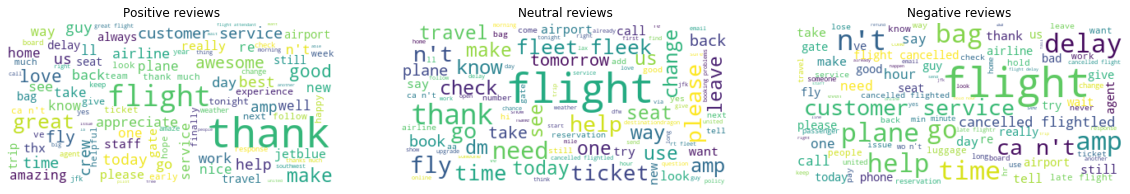

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pos_text = " ".join(df_airlines[df_airlines.classification==1].text.values)
neg_text = " ".join(df_airlines[df_airlines.classification==-1].text.values)
neu_text = " ".join(df_airlines[df_airlines.classification==0].text.values)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_text)
wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neu_text)

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title('Positive reviews')
plt.subplot(1,3,2)
plt.imshow(wordcloud_neu, interpolation="bilinear")
plt.axis("off")
plt.title('Neutral reviews')
plt.subplot(1,3,3)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title('Negative reviews')
plt.savefig('figures/airline_wordclouds.png')
plt.show()

#### Wordclouds for the sentiment dataset

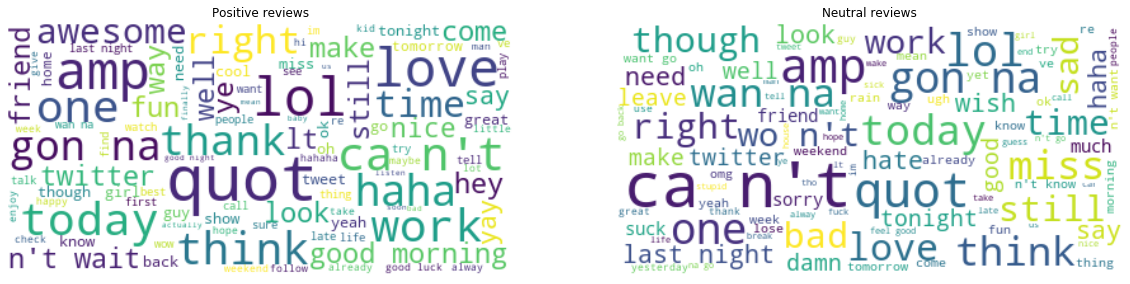

In [9]:
pos_text = " ".join(df_sentiment[df_sentiment.classification==1].text.values)
neg_text = " ".join(df_sentiment[df_sentiment.classification==-1].text.values)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_text)

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title('Positive reviews')
plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title('Neutral reviews')
plt.savefig('figures/sentiment_wordclouds.png')
plt.show()

## Feature extraction

###  TF-IDF Vectorizer without bag of words

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5,
                            norm='l2',
                            ngram_range=(1,1))

x_train = vectorizer.fit_transform(df_airlines.text.values).toarray()
y_train = df_airlines.classification.values
x_train.shape

(14604, 2390)

### TF-IDF Vectorizer with bag of words

In [11]:
vectorizer_bow = TfidfVectorizer(min_df=5,
                                norm='l2',
                                ngram_range=(1,3))

x_train_bow = vectorizer_bow.fit_transform(df_airlines.text.values).toarray()
x_train_bow.shape

(14604, 4872)

## Classification

In [12]:
from time import time
start = time()

### Naive Bayes

#### Without bag of words

In [13]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB

kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train), total=4):
    classifier = MultinomialNB()
    classifier.fit(x_train[train_index], y_train[train_index])
    scores.append(classifier.score(x_train[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores))

0.7386332511640646

#### With bag of words

In [14]:
kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    classifier = MultinomialNB()
    classifier.fit(x_train_bow[train_index], y_train[train_index])
    scores.append(classifier.score(x_train_bow[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores))

0.7415091755683374

### SVM

#### Without bag of words

In [15]:
from sklearn.svm import SVC

kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train), total=4):
    classifier = SVC()
    classifier.fit(x_train[train_index], y_train[train_index])
    scores.append(classifier.score(x_train[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores))

0.7774582306217475

#### With bag of words

In [16]:
kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    classifier = SVC()
    classifier.fit(x_train_bow[train_index], y_train[train_index])
    scores.append(classifier.score(x_train_bow[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores))

0.7736236647493838

### Random forest

#### Without bag of words

In [17]:
from sklearn.ensemble import RandomForestRegressor

tmp = time()

kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train), total=4):
    classifier = RandomForestRegressor(n_estimators=50)
    classifier.fit(x_train[train_index], y_train[train_index])
    scores.append(classifier.score(x_train[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores)), time()-tmp

(0.41307500306587913, 1984.1540126800537)

#### With bag of words

In [18]:
tmp = time()

kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    classifier = RandomForestRegressor(n_estimators=50)
    classifier.fit(x_train_bow[train_index], y_train[train_index])
    scores.append(classifier.score(x_train_bow[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores)), time()-tmp

(0.4187675237178638, 3788.2292382717133)

### Boosted Trees

#### Without bag of words

In [19]:
from sklearn.ensemble import AdaBoostClassifier

kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train), total=4):
    classifier = AdaBoostClassifier()
    classifier.fit(x_train[train_index], y_train[train_index])
    scores.append(classifier.score(x_train[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores))

0.7072719802793755

#### With bag of words

In [20]:
kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    classifier = AdaBoostClassifier()
    classifier.fit(x_train_bow[train_index], y_train[train_index])
    scores.append(classifier.score(x_train_bow[test_index], y_train[test_index]))
    
np.mean(np.asarray(scores))

0.70679265954533

### Fully connected network

In [21]:
# Converting to one_hot
def one_hot(x):
    classes = np.unique(x)
    array = np.zeros((*x.shape, classes.shape[0]), dtype=np.int)
    for i, classe in enumerate(classes):
        vector = np.zeros((1,classes.shape[0]), dtype=np.int)
        vector[:,i]=1
        array[x==classe] = vector
    return classes, array

classes, y_train = one_hot(y_train)

In [31]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.regularizers import l2

def FCN(x_train, y_train, x_test, y_test, nodes_1=2000, nodes_2=None):
    model = Sequential()
    model.add(InputLayer(input_shape=(x_train.shape[1])))
    model.add(Dense(units=nodes_1,
                    activation='relu',
                    kernel_initializer='lecun_normal'))
    model.add(Dropout(rate=0.5))
    
    if nodes_2:
        model.add(Dense(units=nodes_2,
                    activation='relu',
                    kernel_initializer='lecun_normal'))
        model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=y_train.shape[1], 
                    activation='softmax', 
                    kernel_initializer='lecun_normal'))
    
    METRICS = [CategoricalAccuracy(name='accuracy'),
               Precision(name='precision'),
               Recall(name='recall'),
               AUC(name='auc')]

    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=METRICS)
    model.summary()
    
    earlystop = EarlyStopping(monitor='val_loss',
                             patience=15,
                             restore_best_weights=True)
    reduceLR = ReduceLROnPlateau(monitor='val_loss',
                                factor=np.sqrt(1e-1),
                                verbose=1,
                                patience=5)
    history = model.fit(x=x_train,
                        y=y_train,
                        batch_size=32,
                        epochs=10000,
                        verbose=0,
                        callbacks=[earlystop, reduceLR],
                        validation_split=0.3,
                        shuffle=True,
                        workers=2)
    
    return model.evaluate(x_test, y_test, verbose=0)

#### Without bag of words

In [ ]:
kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    avg = np.mean(x_train[train_index])
    scores.append(FCN(x_train[train_index]-avg,
                      y_train[train_index],
                      x_train[test_index]-avg,
                      y_train[test_index],
                      nodes_1=50,
                      nodes_2=None))

print(np.mean(np.asarray(scores), axis=0))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 50)                119550    
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 153       
Total params: 119,703
Trainable params: 119,703
Non-trainable params: 0
_________________________________________________________________


#### With bag of words

In [24]:
kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    scores.append(FCN(x_train_bow[train_index], 
                      y_train[train_index],
                      x_train_bow[test_index],
                      y_train[test_index],
                      nodes_1=50,
                      nodes_2=None))
    
print(np.mean(np.asarray(scores), axis=0))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                243650    
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 153       
Total params: 243,803
Trainable params: 243,803
Non-trainable params: 0
_________________________________________________________________

Epoch 00235: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.

Epoch 00240: ReduceLROnPlateau reducing learning rate to 9.99999983430526e-07.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 3.162277652184396e-07.

Epoch 00250: ReduceLROnPlateau reducing learning rate to 9.999999654550589e-08.
Model: "sequential_5"
________________________________

### LSTM network

In [28]:
from tensorflow.keras.layers import Bidirectional, LSTM

def RNN(x_train, y_train, x_test, y_test, nodes_1=64, nodes_2=None):
    model = Sequential()
    model.add(InputLayer(input_shape=(x_train.shape[1])))
    model.add(Bidirectional(LSTM(units=nodes_1)))
    model.add(Dropout(rate=0.4))
    
    if nodes_2:
        model.add(Bidirectional(LSTM(units=nodes_2)))
        model.add(Dropout(rate=0.4))
    
    model.add(Dense(units=y_train.shape[1], 
                    activation='softmax', 
                    kernel_initializer='lecun_normal'))
    
    METRICS = [CategoricalAccuracy(name='accuracy'),
               Precision(name='precision'),
               Recall(name='recall'),
               AUC(name='auc')]

    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=METRICS)
    model.summary()
    
    earlystop = EarlyStopping(monitor='val_loss',
                             patience=15,
                             restore_best_weights=True)
    reduceLR = ReduceLROnPlateau(monitor='val_loss',
                                factor=np.sqrt(1e-1),
                                verbose=1,
                                patience=5)
    history = model.fit(x=x_train,
                        y=y_train,
                        batch_size=32,
                        epochs=10000,
                        verbose=0,
                        callbacks=[earlystop, reduceLR],
                        validation_split=0.3,
                        shuffle=True,
                        workers=2)
    
    return model.evaluate(x_test, y_test, verbose=0)

#### Without bag of words

In [30]:
kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    scores.append(RNN(x_train[train_index],
                      y_train[train_index],
                      x_train[test_index],
                      y_train[test_index],
                      nodes_1=64,
                      nodes_2=None))

print(np.mean(np.asarray(scores), axis=0))

ValueError: Input 0 of layer bidirectional is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 2390]

#### With bag of words

In [ ]:
kf = KFold(n_splits=4, shuffle=True)
scores = []
for train_index, test_index in tqdm(kf.split(x_train_bow), total=4):
    scores.append(RNN(x_train_bow[train_index],
                      y_train[train_index],
                      x_train_bow[test_index],
                      y_train[test_index],
                      nodes_1=64,
                      nodes_2=None))

print(np.mean(np.asarray(scores), axis=0))

## End of comparison of models

In [25]:
print('Time spent on model tuning :', time()-start)

Time spent on model tuning : 14040.185913801193


## Evaluation on test datasets

### Sentiment140 dataset (tweets)

### Amazon book reviews